# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2
from my_unity_environment import MyUnityEnvironment
from tennis_environment import TennisEnvironment
from model import Actor, Critic
from ddpg_agents import DDPGAgents
from ddpg_agent import DDPGAgent
from replay_buffer import ReplayBuffer
from utilities import convert_to_tensor, convert_to_numpy
import numpy as np
import torch
import torch.nn.functional as f
import random
from collections import deque
import sys
import time
import matplotlib.pyplot as plt
%matplotlib inline


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
ENV_FILE_NAME = "Tennis.app"
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
ENV_FILE_NAME = "Tennis_Windows_x86_64/Tennis.exe"

#test_env = MyUnityEnvironment(file_name=ENV_FILE_NAME)
test_env = MyUnityEnvironment(file_name=ENV_FILE_NAME, no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
def examine_environment(myenv: MyUnityEnvironment):
    # number of agents in the environment
    print('Number of agents:', myenv.num_agents)

    # number of actions
    print('Size of each action:', myenv.action_size)

    # examine the state space
    print('States look like:', myenv.get_states()[0])
    print('States have length:', myenv.state_size)


examine_environment(test_env)

Number of agents: 2
Size of each action: 2
States look like: tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -6.6528, -1.5000, -0.0000,  0.0000,  6.8317,  6.0000, -0.0000,  0.0000],
       device='cuda:0')
States have length: 24


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [4]:
def test_random_agents(myenv: MyUnityEnvironment):
    for i in range(10):  # play game for 10 episodes
        myenv.reset()  # reset the environment
        scores = np.zeros(myenv.num_agents)  # initialize the score
        while True:
            actions = np.random.randn(myenv.num_agents, myenv.action_size)  # select an action (for each agent)
            actions = np.clip(actions, -1, 1)  # clip action values between -1 and 1
            _, rewards, dones = myenv.step(actions)  # send all actions to the environment
            scores += convert_to_numpy(rewards).squeeze()  # update the score  (for each agent)
            if torch.any(dones):  # exit loop if episode finished
                break
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

#test_random_agents(test_env)

### 4. Train the Agents with DDPG

Run the code cell below to train the agents from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**5. Watch Smart Agents!**), to load the saved model weights from pre-trained agents.

In [5]:
class DDPGAgentsTester:
    def __init__(self, ddpg_agents: DDPGAgents,
                 myenv: MyUnityEnvironment,
                 random_seed=1,
                 buffer_size=100000,  # replay buffer size
                 noise_start=1.0
                 ):
        self.ddpg_agents = ddpg_agents
        self.myenv = myenv
        self.buffer_size = buffer_size
        self.scores = []
        self.scores_deque = deque(maxlen=100)
        self.episode = 0
        self.noise = noise_start
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        random.seed(random_seed)
        #torch.set_num_threads(self.parallel_envs)
        self.replay_buffer = ReplayBuffer(buffer_size)

    def train_agents(self, n_episodes=10000, max_t=5000, goal=float("inf"), print_every=1000, update_every=1, num_updates=5,
                     batch_size=1000, noise_decay=3e-6):
        """ Multi Agent Deep Deterministic Policy Gradient algorithm.

        Params
        ======
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            goal (float): the algorithm will stop when the goal is reached
            print_every (int) : print intermediate results every %print_every episodes
            update_every (int): update the neural networks every %update_every episodes
            num_updates: How many updates to do in a row
            batch_size (int): minibatch size
            noise_decay (float): noise decay factor = 1.0 - %noise_decay
        """
        noise_decay = 1.0 - noise_decay
        start_episode = self.episode
        stop_episode = self.episode + n_episodes
        steps = 0
        start_time = time.time()
        for self.episode in range(start_episode, stop_episode):
            score = np.zeros(len(self.ddpg_agents))
            self.myenv.reset(train_mode=True)
            states = self.myenv.get_states()
            for t in range(max_t):
                steps += 1
                # step forward one frame:
                actions = self.ddpg_agents.act(states, self.noise)
                next_states, rewards, dones = self.myenv.step(actions)

                # add sample to replay buffer:
                actions = convert_to_tensor(np.vstack(actions))
                sample = (states, actions, rewards, next_states, dones)
                self.replay_buffer.add(sample)

                states = next_states
                self.noise *= noise_decay
                score += convert_to_numpy(rewards).squeeze()

                if torch.any(dones):  # exit loop if episode finished
                    break

            # update networks every %update_every episodes:
            if self.episode % update_every == 0 and len(self.replay_buffer) > self.buffer_size / 2:
                for _ in range(num_updates):
                    samples = [self.replay_buffer.sample(batch_size) for _ in range(len(self.ddpg_agents))]
                    self.ddpg_agents.step(samples)
                    self.ddpg_agents.update_target_networks()  #soft update the target network towards the actual networks

            self.scores_deque.append(score)
            self.scores.append(score)
            average_scores = np.mean(self.scores_deque, 0)  # average score over last 100 episodes for each agent
            time_per_step = (time.time() - start_time) / steps
            print('\rEpisode {}\tSteps: {}\tTime per step: {:.6f}\tAverage Scores: {:.3f} {:.3f}'
                  .format(self.episode, steps, time_per_step, *average_scores), end="")
            if self.episode % print_every == 0:
                print("\r                                                                                                       "\
                      , end="")
                print('\rEpisode {}\tAverage Scores: {:.3f} {:.3f}'.format(self.episode, *average_scores))
            if len(self.scores) >= print_every and np.max(average_scores) >= goal:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\tTime elapsed: {}'.format(
                    self.episode, np.max(average_scores), time.time() - start_time))
                break

    def test_agent(self):
        for _ in range(10):
            self.myenv.reset(train_mode=True)
            states = self.myenv.get_states()
            score = np.zeros(len(self.ddpg_agents))
            while True:
                actions = self.ddpg_agents.act(states, 0.0)
                # step forward one frame
                next_states, rewards, dones = self.myenv.step(actions)
                score += convert_to_numpy(rewards).squeeze()
                states = next_states
                if torch.any(dones):  # exit loop if episode finished
                    break
            print("Score: {}".format(score))

In [8]:
actor1 = Actor(state_size=24, action_size=2, hidden_layer_sizes=[256, 128, 64], activation_func=f.leaky_relu)
actor2 = Actor(state_size=24, action_size=2, hidden_layer_sizes=[256, 128, 64], activation_func=f.leaky_relu)
critic1 = Critic(state_size=24, action_size=2, hidden_layer_sizes=[256, 128, 64], activation_func=f.leaky_relu,
                 inject_layer=0)
critic2 = Critic(state_size=24, action_size=2, hidden_layer_sizes=[256, 128, 64], activation_func=f.leaky_relu,
                 inject_layer=0)
ddpg_agent1 = DDPGAgent(actor1, critic1, gamma=0.99, tau=1e-3, lr_actor=1e-4, lr_critic=1e-4, weight_decay=0.0)
ddpg_agent2 = DDPGAgent(actor2, critic2, gamma=0.99, tau=1e-3, lr_actor=1e-4, lr_critic=1e-4, weight_decay=0.0)
ddpg_agent_list = [ddpg_agent1, ddpg_agent2]
ddpg_agents = DDPGAgents(ddpg_agent_list)
ddpg_agents_tester = DDPGAgentsTester(ddpg_agents, test_env, random_seed=1, buffer_size=100000, noise_start=1.0)

In [9]:
ddpg_agents_tester.train_agents(n_episodes=60000, goal=0.5, update_every=1, num_updates=5, batch_size=1000,
                                noise_decay=3e-6, max_t=240)
ddpg_agents.save_checkpoint("checkpoint.pth")

Episode 0	Average Scores: -0.010 0.100                                                                 
Episode 1000	Average Scores: 0.002 0.005                                                               
Episode 2000	Average Scores: 0.009 0.007                                                               
Episode 3000	Average Scores: 0.020 -0.007                                                              
Episode 4000	Average Scores: -0.005 0.016                                                              
Episode 5000	Average Scores: -0.004 0.038                                                              
Episode 6000	Average Scores: 0.049 0.057                                                               
Episode 7000	Average Scores: 0.085 0.085                                                               
Episode 8000	Average Scores: 0.189 0.205                                                               
Episode 9000	Average Scores: 0.257 0.242                        

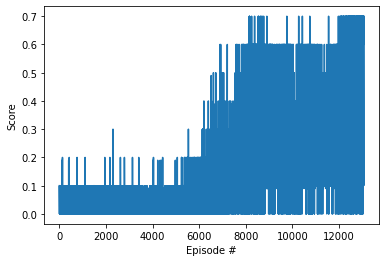

In [10]:
scores = np.vstack(ddpg_agents_tester.scores)
scores = np.max(scores, 1)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch Smart Agents!

In [11]:
ddpg_agents.load_checkpoint("checkpoint.pth")
ddpg_agents_tester.test_agent()

Score: [2.60000004 2.60000004]
Score: [2.30000003 2.29000003]
Score: [0.29000001 0.3       ]
Score: [2.60000004 2.60000004]
Score: [2.10000003 1.99000003]
Score: [1.40000002 1.39000002]
Score: [1.50000002 1.39000002]
Score: [2.60000004 2.60000004]
Score: [2.60000004 2.70000004]
Score: [2.70000004 2.60000004]


When finished, you can close the environment.

In [11]:
test_env.close()